<a href="https://colab.research.google.com/github/finfrierson/data-science-fundamentals/blob/main/project_8_actuall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import seaborn as sns
!pip install pymc-bart
import pymc_bart as pmb

I acquired a dataset from the city of Austin that provides data on electric bike trips - including when and where they were checked out and more. To me this is interesting, because whenever I'm in downtown Austin I see that there are so many of these rentable transportation, and I feel that it is rare that they are ever used. I wanted to see that they are actually being used, and how so.

In [135]:
url="https://raw.githubusercontent.com/finfrierson/data-science-fundamentals/refs/heads/main/Austin_MetroBike_Trips_20250402%20(1).csv"
bikes = pd.read_csv(url)

In [136]:
bikes

,Trip ID,Membership or Pass Type,Bicycle ID,Bike Type,Checkout Datetime,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
0,33869739,Student Membership,21499,electric,06/30/2024 11:44:03 PM,06/30/2024,23:44:03,4938,22.5/Rio Grande,7189,28th/Rio Grande,7,6,2024
1,33869737,Explorer,19935,electric,06/30/2024 11:42:44 PM,06/30/2024,23:42:44,2495,4th/Congress,7253,Barton Springs/Riverside,5,6,2024
2,33869687,Student Membership,22431,electric,06/30/2024 11:26:20 PM,06/30/2024,23:26:20,3621,3rd/Nueces,4062,Lakeshore/Pleasant Valley,20,6,2024
3,33869674,Student Membership,270G,classic,06/30/2024 11:24:27 PM,06/30/2024,23:24:27,7188,22nd/Pearl,3838,26th/Nueces,5,6,2024
4,33869651,Student Membership,21423,electric,06/30/2024 11:14:47 PM,06/30/2024,23:14:47,3798,21st/Speedway @ PCL,2498,Dean Keeton/Speedway,4,6,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141139,32235861,Local365,19177,electric,01/01/2024 12:17:06 AM,01/01/2024,0:17:06,2566,Electric Drive/Sandra Muraida Way @ Pfluger Pe...,2542,Plaza Saltillo,15,1,2024
141140,32235858,Local31,21728,electric,01/01/2024 12:16:52 AM,01/01/2024,0:16:52,2549,South 1st/Riverside @ Long Center,2549,South 1st/Riverside @ Long Center,2,1,2024
141141,32235855,Local31,22449,electric,01/01/2024 12:15:50 AM,01/01/2024,0:15:50,2539,3rd/Trinity @ The Convention Center,2566,Electric Drive/Sandra Muraida Way @ Pfluger Pe...,14,1,2024
141142,32235854,Student Membership,18532,electric,01/01/2024 12:15:41 AM,01/01/2024,0:15:41,2549,South 1st/Riverside @ Long Center,3293,East 2nd/Pedernales,21,1,2024


I found that my data set actually had way too much. When I imported it I had so many rows of data that I could not even upload it to github. I trimmed it down to just 2024 data, which only includes up through June as of when I imported it. Despite this, my data STILL had over 140,000 rows, with each being a trip on one of these bikes. The following code fixes formatting - switching text variables into numbers and cobining day and month for a one number representation of date - alongside reducing extreme outliers. There were a few data points in which a trip was logged for thousands of minutes, with the longest being ~4000 minutes - which is approaching 3 full days. I believe that these are not representative of the true statistics and have removed them, even if that causes some bias (it also makes my model look nicer). Lastly, as I still had way too man rows for my model to reasonably run, I sampled it down to only 2000, as that can still be a good representation of the population.

In [137]:
#Sampling to reduce model runtime
bikes=bikes.sample(n=2000)

In [138]:
bikes.reset_index(drop=True,inplace=True)

In [139]:
num = 0
while num < len(bikes):
  #Changing date and time of day each into one float (rather than having a string) for easy use by my model.
    date = bikes.loc[num, "Checkout Date"]
    bikes.loc[num, "Checkout Date"] = int(date[1]) + int(date[3:5]) / 31

    time = bikes.loc[num, "Checkout Time"]
    if len(time) == 7:
        bikes.loc[num, "Checkout Time"] = int(time[0]) + int(time[2:4]) / 60
    else:
        bikes.loc[num, "Checkout Time"] = int(time[0:2]) + int(time[3:5]) / 60
    #Removing outliers over 10 hours of use, as I believe these are errors or misrepresentaitive of my data.
    if bikes.loc[num, "Trip Duration Minutes"] > 300:
      bikes.loc[num, "Trip Duration Minutes"]=bikes.loc[num, "Checkout Time"]/30
    num += 1

<ipython-input-139-0d97c7fcce7f>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6077777777777779' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  bikes.loc[num, "Trip Duration Minutes"]=bikes.loc[num, "Checkout Time"]/30


Checkout time, date, and duration of trip were the easiest variables to turn into numerical values, thus I chose to use those three for my model. Based on a causal diagram and simple logic, I think that Trip duration would be explainable by date and time of bike checkout.

In [140]:
X = bikes[[
             'Checkout Time',
             'Month'
]]
Y = bikes["Trip Duration Minutes"].to_numpy()

#Model Attempt 1

In [141]:
# All integer values provided here were the defaults given by mr Arredondo, along with the log.
with pm.Model() as model_bike:
    s = pm.HalfNormal('s',2)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=5)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_bike = pm.sample(compute_convergence_checks=False)

Output()

In [142]:
pm.sample_posterior_predictive(idata_bike,model_bike, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 100.0)

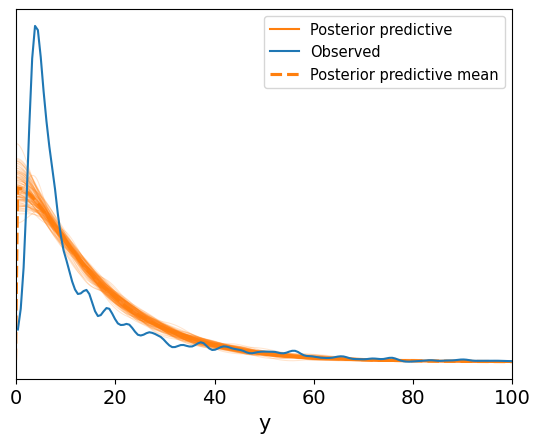

In [143]:
ax = az.plot_ppc(idata_bike, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(0.0,100)

This model is kind of terrible. It captures a somewhat accurate trend but understimates at the start without capturing the behavior well and follows too smooth of a curve in the middle, casing an overestimation and innacuracy to the data.  I'm going to attempt to switch up some values and the likelihood in my model as to create a new and more accurate one.

In [144]:
posterior_mean = idata_bike.posterior["μ"]

μ_hdi = az.hdi(ary=idata_bike, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_bike, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


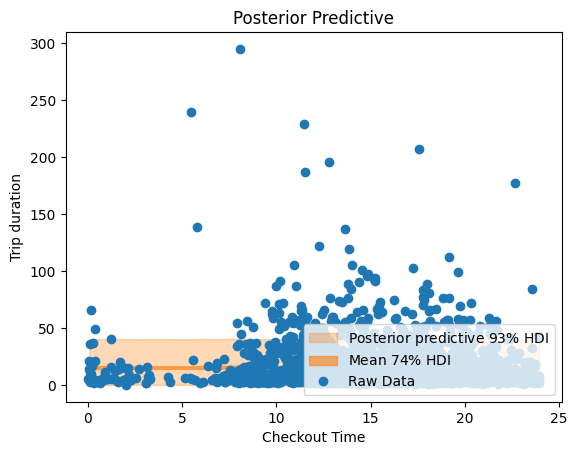

In [145]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab fifth row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab fifth row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab fifth row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(bikes['Checkout Time'], bikes["Trip Duration Minutes"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Checkout Time",
    ylabel="Trip duration",
);

#Model Attempt 2

In [146]:
# All integer values provided here were the defaults given by mr Arredondo, along with the log.
with pm.Model() as model_bike2:
    s = pm.HalfNormal('s',2)
    n = pm.HalfNormal('n',2)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=5)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.ExGaussian("y", mu=μ, sigma=s,nu=n, observed=Y)
    idata_bike2 = pm.sample(compute_convergence_checks=False)

Output()

In [147]:
pm.sample_posterior_predictive(idata_bike2,model_bike2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 50.0)

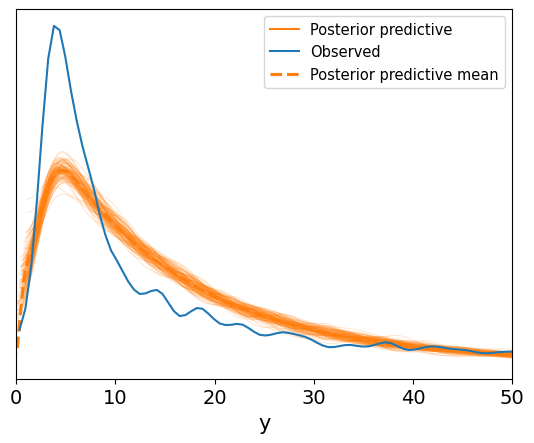

In [148]:
ax = az.plot_ppc(idata_bike2, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(0.0,50)

This is a little bit better. While not a perfect model it captures the trends accurately, and that is good enough.

In [149]:
posterior_mean = idata_bike2.posterior["μ"]

μ_hdi = az.hdi(ary=idata_bike2, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_bike2, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


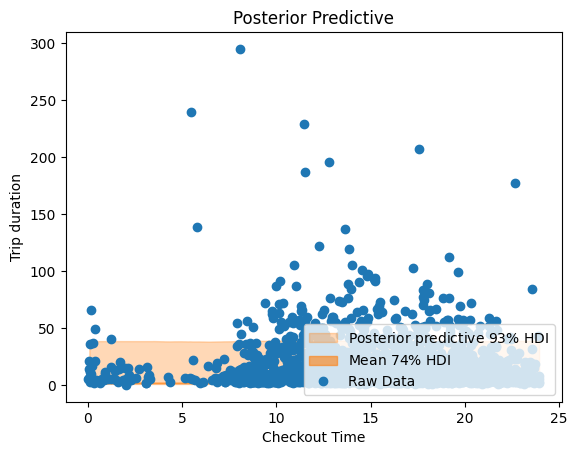

In [150]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab fifth row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab fifth row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab fifth row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(bikes['Checkout Time'], bikes["Trip Duration Minutes"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Checkout Time",
    ylabel="Trip duration",
);

In [131]:
#This is fixing the data type of my X columns from obkects into floating point numbers.
for col in X.columns:
  X[col] = X[col].astype(float)


<ipython-input-131-14ca2142b098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(float)
<ipython-input-131-14ca2142b098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(float)


array([<Axes: xlabel='Checkout Time'>, <Axes: xlabel='Month'>],
      dtype=object)

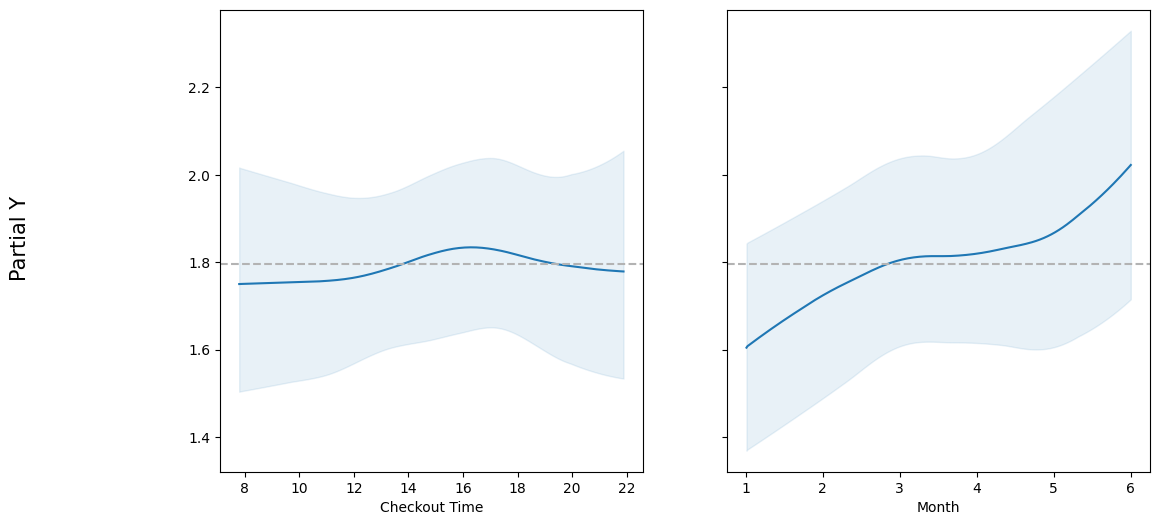

In [133]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 2), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='Checkout Time'>, <Axes: xlabel='Month'>],
      dtype=object)

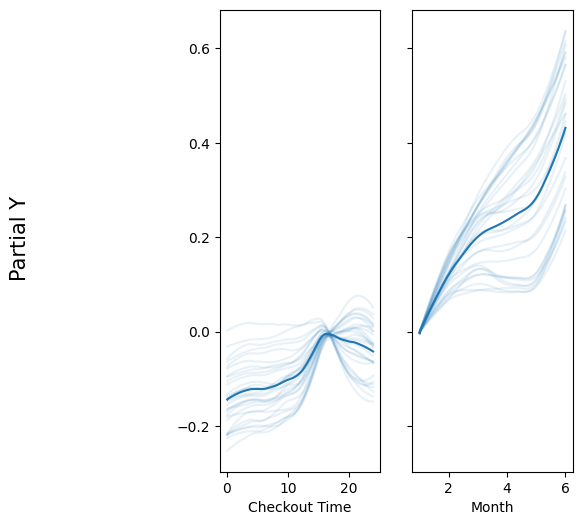

In [132]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

These two plots are important as they show that the increase in duration of bike rides is more heavily attributed to the date rather than the time they are checked out. This is quite reasonable, as there is a larger shift in temperature and conditions on a monthly basis than throughout the day.

#Conclusion

My findings show that while both the time of day and date have an effect on the length in minutes of a rented bike ride, the date is a more significant factor.